In [1]:
import pandas as pd
import numpy as np

In [2]:
def load_train_test(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    train_features = np.append(test.columns, 'NU_NOTA_MT')
    train = train.loc[:, train_features]
    return train, test

## Acquiring data

In [3]:
train, test = load_train_test('train.csv', 'test.csv')

###  Analisando dados faltantes

Total relativo de dados faltantes em bases de treino e teste. 

In [4]:
def missing(dataframe, name='missing'):
    missing = dataframe.isnull().mean().sort_values(ascending=False).to_frame(name)
    return missing[missing.iloc[:, 0] > 0]

In [5]:
pd.concat([missing(test, 'test_missing'), missing(train, 'train_missing')], axis=1)

,test_missing,train_missing
TP_ENSINO,0.676573,0.688128
TP_DEPENDENCIA_ADM_ESC,0.676573,0.688128
Q027,0.543706,0.536999
TP_STATUS_REDACAO,0.262019,0.261981
NU_NOTA_COMP4,0.262019,0.261981
NU_NOTA_LC,0.262019,0.261981
NU_NOTA_COMP1,0.262019,0.261981
NU_NOTA_COMP2,0.262019,0.261981
NU_NOTA_COMP3,0.262019,0.261981
NU_NOTA_COMP5,0.262019,0.261981


#### Features de notas
Das 14 features com dados faltantes 11 são relacionadas às notas de pessoas que faltaram ou foram eliminadas.

- Se o aluno faltou ou foi eliminado em alguma prova, de acordo com as variáveis de presença, não há nota para o participante naquela prova. 
    - Neste caso substituir notas por zero.

![TP_PRESENCA](screenshots/tp_presenca.png)

As features `TP_PRESENCA_CN`,` TP_PRESENCA_CH`, `TP_PRESENCA_LC` podem assumir apenas 0, 1 ou 2 de acordo com o dicionário de dados. Verificando se há algum valor nulo ou fora do intervalo

In [6]:
attendance = train[['TP_PRESENCA_CN','TP_PRESENCA_CH','TP_PRESENCA_LC']].copy()
pd.DataFrame(
    data = {
    'total NaN': attendance.isnull().sum().values,
    'unique': [attendance[it].unique() for it in attendance.columns]
    },
    index=attendance.columns
)

,total NaN,unique
TP_PRESENCA_CN,0,"[1, 0, 2]"
TP_PRESENCA_CH,0,"[1, 0, 2]"
TP_PRESENCA_LC,0,"[1, 0, 2]"


#### Q1
Todas notas são nulas quando as features de presença (`TP_PRESENCA_CN`,` TP_PRESENCA_CH`, `TP_PRESENCA_LC`) são diferentes de 1?


In [7]:
(
    train.loc[train['TP_PRESENCA_CN'] != 1, 'NU_NOTA_CN'].isnull().all(),
    train.loc[train['TP_PRESENCA_CH'] != 1, 'NU_NOTA_CH'].isnull().all(),
    train.loc[
        train['TP_PRESENCA_LC'] != 1, 
        ['NU_NOTA_LC','NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5','NU_NOTA_REDACAO','TP_STATUS_REDACAO','NU_NOTA_MT']
    ].isnull().all().all()
)

(True, True, True)

<hr>

- `TP_STATUS_REDACAO` possui todos valores nulos quando `TP_PRESENCA_LC` é diferente de 1, ou seja, quando o aluno faltou ou foi eliminado na prova de Linguagens.
    - Se faltou então `TP_STATUS_REDACAO` deve ser 4 (ficou em branco)
    - Se foi eliminado `TP_STATUS_REDACAO` deve ser 2 (anulada)


![TP_STATUS_REDACAO](screenshots/tp_status.png)


- `TP_DEPENDENCIA_ADM_ESC` e `TP_ENSINO`: 
    - conclusão: têm relação com a feature `TP_ESCOLA` que quando é `1` e `4` (não informado e exterior) resulta em missing data em ambas. 
        - 1. Apaga feature;
        - 2. ou Imputa. (moda, criar nova categoria)

In [8]:
print('Valores nulos por TP_ESCOLA')
train[['TP_ENSINO','TP_DEPENDENCIA_ADM_ESC']].isnull().groupby(train['TP_ESCOLA']).sum().astype(int)

Valores nulos por TP_ESCOLA


,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC
TP_ESCOLA,,
1,9447,9447
2,0,0
3,0,0
4,1,1


### Q2
Quando `TP_ESCOLA` não é informado (1) ou é exterior (4) `TP_ENSINO` e `TP_DEPENDENCIA_ADM_ESC` são ambas nulas para todas observações?

In [9]:
data = train.loc[
    (train.TP_ESCOLA == 1) | (train.TP_ESCOLA == 4), ['TP_ESCOLA','TP_ENSINO','TP_DEPENDENCIA_ADM_ESC']
]
(data.TP_ENSINO.isnull() & data.TP_DEPENDENCIA_ADM_ESC.isnull()).all()

True

- `Q27`:
    - valores ausentes: não informaram idade:
        - 1. Apaga feature;
        - 2. ou Imputa. (moda, criar nova categoria)

In [10]:
(train.Q027.value_counts(dropna=False)/train.shape[0]*100).plot(kind='barh');


## Helpers - preparando os dados
Após análisar dicionário de dados e os dados nas células acima se faz necessário alguns ajustes nos dados.

In [11]:
to_float = [it for it in test.columns.values if 'NU_NOTA' in it]    
to_category = [it for it in test.columns.values if 'NU_' not in it] 
to_float.append('NU_NOTA_MT')
to_float

['NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'NU_NOTA_MT']

In [12]:
from sklearn.preprocessing import KBinsDiscretizer

def impute_grades_with_0(train, test):
    impute_grades = {
        'TP_PRESENCA_CN': ['NU_NOTA_CN'], 
        'TP_PRESENCA_CH': ['NU_NOTA_CH'], 
        'TP_PRESENCA_LC': [
            'NU_NOTA_LC', 
            'NU_NOTA_COMP1', 
            'NU_NOTA_COMP2', 
            'NU_NOTA_COMP3', 
            'NU_NOTA_COMP4', 
            'NU_NOTA_COMP5', 
            'NU_NOTA_REDACAO', 
            'NU_NOTA_MT'
        ]
    }   
    for attendance, grades in impute_grades.items():
        train.loc[(train[attendance] != 1), grades] = 0
        
    impute_grades['TP_PRESENCA_LC'].remove('NU_NOTA_MT')
    
    for attendance, grades in impute_grades.items():
        test.loc[(test[attendance] != 1), grades] = 0
        
    # se faltou prova ficou em branco(4), se eliminado foi anulada (2)
    train.loc[train.TP_PRESENCA_LC == 2, 'TP_STATUS_REDACAO'] = 2
    train.loc[train.TP_PRESENCA_LC == 0, 'TP_STATUS_REDACAO'] = 4
    test.loc[train.TP_PRESENCA_LC == 2, 'TP_STATUS_REDACAO'] = 2
    test.loc[train.TP_PRESENCA_LC == 0, 'TP_STATUS_REDACAO'] = 4
    
def discretize_nu_idade(train, test):
    discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
    discretizer.fit(train[['NU_IDADE']])
    # discretizando o train
    train['NU_IDADE'] = discretizer.transform(train[['NU_IDADE']]).astype(int)
    train['NU_IDADE'] = train['NU_IDADE'].astype('category')
    # discretizando o test
    test['NU_IDADE'] = discretizer.transform(test[['NU_IDADE']]).astype(int)
    test['NU_IDADE'] = test['NU_IDADE'].astype('category')

def map_cod_prova_to_numeric(train, test):    
    for it in ['CO_PROVA_CN','CO_PROVA_CH','CO_PROVA_LC','CO_PROVA_MT']:
        cats = train[it].unique()
        maping = dict(zip(cats, np.arange(1, cats.size+1)))
        train[it] = train[it].map(maping).astype('category')
        test[it] = test[it].map(maping).astype('category')
        
def discard_features(train, test):
    to_discard = [
        # já existe CO_UF_RESIDENCIA
        'SG_UF_RESIDENCIA', 
        # só diz respeito a quem já concluiu (nem todos concluíram)
        'TP_ANO_CONCLUIU', 
        # features com missing data: a princípio serão excluídas do modelo
        'TP_ENSINO', 
        'TP_DEPENDENCIA_ADM_ESC',
        'Q027',
        # tem apenas uma classe (0)
        'IN_CEGUEIRA'
    ]
    train.drop(to_discard, inplace=True, axis=1)
    test.drop(to_discard, inplace=True, axis=1)   
        
def correct_dtypes(train, test):
    size = lambda x: round(x.memory_usage().sum() / (1024*1024), 3)        
    to_float = [it for it in test.columns.values if 'NU_NOTA' in it]    
    to_category = [it for it in test.columns.values if 'NU_' not in it] 
    
    size_before = (size(train), size(test))
    
    test[to_float] = test[to_float].astype(float)
    to_float.append('NU_NOTA_MT')
    train[to_float] = train[to_float].astype(float)    
    test[to_category] = test[to_category].astype('category')
    train[to_category] = train[to_category].astype('category')        
    size_after = (size(train), size(test))    
    return size_before, size_after

def anova_selection(train):
    from AnovaTest import AnovaTest as tt
    anova_test = tt(train, train.columns).run()
    anova_test = pd.DataFrame(
        data=anova_test, 
        columns=['feature', 'F-score', 'P-value']
    ).set_index(
        'feature'
    ).sort_values('P-value', ascending=True)
    anova_test = anova_test[(anova_test['P-value'] < 0.001)].sort_values('F-score', ascending=False)
    return np.append(
        ['NU_INSCRICAO'],
        np.append(
            anova_test[(anova_test['P-value'] < 0.001)].sort_values('F-score', ascending=False).index.values,
            train.select_dtypes(include=float).columns
        )
    )

- Descartar algumas features
- Imputar `NU_NOTA_MT` como 0 (aluno faltou ou foi eliminado)
- Transformar `NU_IDADE` em 4 bins usando estratégia quantile
- Transformar `CO_PROVA*` em numérico categórico (código mto grande)
- Variáveis de notas serão float
    - Todas as outras serão categóricas (economiza uso de memória)
    - `NU_IDADE` continua por enquanto como int

In [13]:
train, test = load_train_test('train.csv', 'test.csv')
discard_features(train, test)
impute_grades_with_0(train, test)
discretize_nu_idade(train, test)
map_cod_prova_to_numeric(train, test)
correct_dtypes(train, test)

((3.943, 1.28), (1.566, 0.492))

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

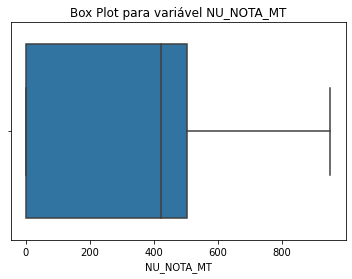

In [15]:
plt.title('Box Plot para variável NU_NOTA_MT')
sns.boxplot(train['NU_NOTA_MT']);

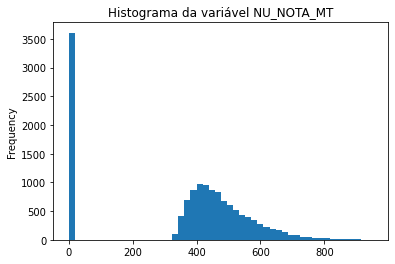

In [16]:
train['NU_NOTA_MT'].plot.hist(
  bins = 50,
  title = "Histograma da variável NU_NOTA_MT"
);

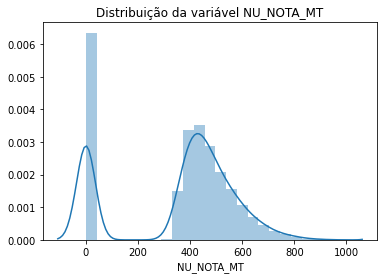

In [17]:
plt.title('Distribuição da variável NU_NOTA_MT')
sns.distplot(train['NU_NOTA_MT']);

In [18]:
train_columns = anova_selection(train)
test_columns = train_columns.copy().tolist()
test_columns.remove('NU_NOTA_MT')
categoricals_columns = train[train_columns].select_dtypes(include='category').columns

In [19]:
print(f'Features selecionadas pelo teste ANOVA: \n{train_columns}')

Features selecionadas pelo teste ANOVA: 
['NU_INSCRICAO' 'TP_PRESENCA_LC' 'TP_PRESENCA_CH' 'TP_PRESENCA_CN'
 'CO_PROVA_LC' 'CO_PROVA_MT' 'CO_PROVA_CH' 'CO_PROVA_CN' 'NU_IDADE' 'Q026'
 'TP_ST_CONCLUSAO' 'Q025' 'Q047' 'TP_LINGUA' 'Q002' 'IN_TREINEIRO' 'Q001'
 'TP_SEXO' 'Q006' 'TP_COR_RACA' 'IN_GESTANTE' 'TP_NACIONALIDADE'
 'CO_UF_RESIDENCIA' 'NU_NOTA_CN' 'NU_NOTA_CH' 'NU_NOTA_LC' 'NU_NOTA_COMP1'
 'NU_NOTA_COMP2' 'NU_NOTA_COMP3' 'NU_NOTA_COMP4' 'NU_NOTA_COMP5'
 'NU_NOTA_REDACAO' 'NU_NOTA_MT']


## Preparando dados para modelo

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

In [21]:
data_to_model = train.loc[:, train_columns].copy()
data_to_test = test.loc[:, test_columns].copy()

In [22]:
data_to_model = pd.concat([data_to_model, pd.get_dummies(data_to_model[categoricals_columns], drop_first=True)], axis=1)
data_to_model.drop(categoricals_columns, axis=1, inplace=True)

data_to_test = pd.concat([data_to_test, pd.get_dummies(data_to_test[categoricals_columns], drop_first=True)], axis=1)
data_to_test.drop(categoricals_columns, axis=1, inplace=True)

## Modelo

In [23]:
X = data_to_model.drop('NU_NOTA_MT', axis=1)
y = data_to_model.loc[:, 'NU_NOTA_MT'].copy()

In [24]:
X.columns.size

132

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression
kbest = SelectKBest(f_regression, k=20)
kbest.fit(X.iloc[:,1:], y)
kbest_features = X.columns.values[1:][kbest.get_support()]
kbest_features

array(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO', 'TP_PRESENCA_LC_1', 'TP_PRESENCA_CH_1',
       'TP_PRESENCA_CN_1', 'CO_PROVA_LC_2', 'CO_PROVA_LC_3',
       'CO_PROVA_LC_5', 'CO_PROVA_MT_2', 'CO_PROVA_MT_3', 'CO_PROVA_MT_5',
       'CO_PROVA_CH_3', 'CO_PROVA_CN_3'], dtype=object)

In [26]:
X = pd.concat([X.iloc[:,0], X.loc[:, kbest_features]], axis=1)
X.shape

(13730, 21)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X.iloc[:, 1:], y, test_size=0.25, random_state=42)

In [28]:
lm_insample = LinearRegression()
lm_insample.fit(x_train, y_train)
yhat_insample = lm_insample.predict(x_train)

In [29]:
r_squared = r2_score(y_train, yhat_insample)
mse = mean_squared_error(y_train, yhat_insample)

print('R2-score: ', r_squared)
print('MSE of G3 and predicted value is: ', mse)

print('*' * 10)
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_train - yhat_insample)))
print("Residual sum of squares (MSE): %.3f" % np.mean((y_train - yhat_insample) ** 2))

R2-score:  0.914463781767183
MSE of G3 and predicted value is:  4430.550264782604
**********
Mean absolute error: 45.72
Residual sum of squares (MSE): 4430.550


In [30]:
lm_outsample = LinearRegression()
lm_outsample.fit(x_train, y_train)
yhat_outsample = lm_outsample.predict(x_test)

In [31]:
r_squared = r2_score(y_test, yhat_outsample)
mse = mean_squared_error(y_test, yhat_outsample)

print('R2-score: ', r_squared)
print('MSE of G3 and predicted value is: ', mse)

print('*' * 10)
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test - yhat_outsample)))
print("Residual sum of squares (MSE): %.3f" % np.mean((y_test - yhat_outsample) ** 2))

R2-score:  0.9184754634690294
MSE of G3 and predicted value is:  4401.67065235006
**********
Mean absolute error: 44.99
Residual sum of squares (MSE): 4401.671


In [32]:
scores = cross_val_score(lm_outsample, X.iloc[:, 1:], y, cv=4)

In [33]:
print('scores: {}\nscores mean: {}'.format(scores, scores.mean()))

scores: [0.91552284 0.91312456 0.91737031 0.9151969 ]
scores mean: 0.9153036523544604


## Visualizando o Modelo

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

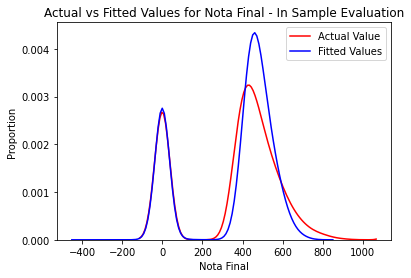

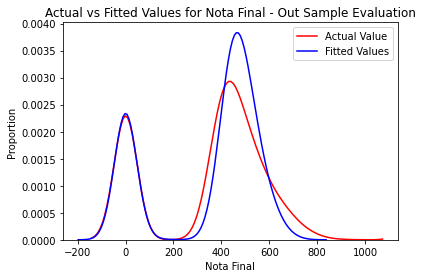

In [35]:
plt.figure()

ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(yhat_insample, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Nota Final - In Sample Evaluation')
plt.xlabel('Nota Final')
plt.ylabel('Proportion')

plt.show()
#plt.savefig('in_sample.png',transparent = True)
plt.close()
######################
plt.figure()

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(yhat_outsample, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Nota Final - Out Sample Evaluation')
plt.xlabel('Nota Final')
plt.ylabel('Proportion')

plt.show()
#plt.savefig('out_sample.png',transparent = True)
plt.close()

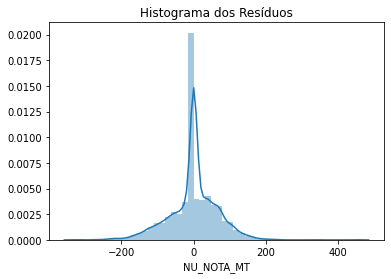

In [36]:
plt.title('Histograma dos Resíduos')
sns.distplot(yhat_outsample - y_test)
plt.show()

### Usando o modelo treinado em test.csv

In [37]:
X_test = pd.concat([data_to_test.iloc[:, 0], data_to_test.loc[:, kbest_features]], axis=1)

In [38]:
X_test['NU_NOTA_MT'] = lm_outsample.predict(X_test.iloc[:, 1:])

In [39]:
answer = X_test.loc[:, ['NU_INSCRICAO', 'NU_NOTA_MT']].copy()
answer.to_csv('answer.csv', index=False)

In [40]:
! codenation submit -c enem-2

Versão: 1.0.14

Usando arquivo de configuração: /home/flavia/.codenation.yml

Executando testes...

{"score": 93.33937029165841}
Preparando code review... 100% |████████████████████████████████████████|  [5s:0s]
Códigos submetidos com sucesso! 

Sua nota é: 93.339370

Parabéns! Você superou este desafio!

O que fazer agora?
- Você pode continuar sua jornada escolhendo um novo desafio em https://www.codenation.com.br
- Você pode ajudar outros desenvolvedores revisando códigos ou respondendo dúvidas no forum do desafio
- Lembre-se que ensinar é uma ótima forma de ganhar reconhecimento e gera um bom karma ;)
